# 02 – Text Preprocessing & Sentiment Analysis

This notebook prepares the cleaned customer support ticket data for modeling. 

I perform:
- Text cleaning (lowercasing, punctuation removal, stopward removal, lemmatization)
- Sentiment analysis using VADER
- TF-IDF vectorization to convert text into numerical features
- Feature engineering combining text and numeric variables

The final ouput of this notebook is a fully processed feature matrix for modeling. 

## Modeling Dataset

We begin with the cleaned modeling dataset created in Notebook 01. 
This dataset includes only closed tickets with valid customer satisfaction ratings. 
The goal in this notebook is to transform the ticket text into structured numerical features that can be used in predicitive modeling. 

In [2]:
import pandas as pd

df_model = pd.read_csv("df_model.csv")
df_model.head()

,Ticket ID,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,desc_word_count,desc_char_count,subject_word_count
0,3,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,NaN,NaN,3.0,42,275,2
1,4,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,NaN,NaN,3.0,41,262,2
2,5,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,NaN,NaN,1.0,55,333,2
3,11,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,High,Phone,NaN,NaN,1.0,38,268,2
4,12,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,High,Chat,NaN,NaN,1.0,50,296,2


## Preparing the Text Processing

To prepare the support ticket descriptions for modeling, we normalize the text by removing
punctuation, numbers, and stopwords, and by reducing words to their base form.  
This produces a clean, comparable version of each ticket’s text (`clean_text`) that reflects
the meaning of the message rather than the customer’s writing style.

In [3]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...


In [5]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

In [6]:
df_model['clean_text'] = df_model['Ticket Description'].apply(clean_text)
df_model[['Ticket Description', 'clean_text']].head()

,Ticket Description,clean_text
0,I'm facing a problem with my {product_purchase...,im facing problem productpurchased productpurc...
1,I'm having an issue with the {product_purchase...,im issue productpurchased please assist proble...
2,I'm having an issue with the {product_purchase...,im issue productpurchased please assist note s...
3,I'm having an issue with the {product_purchase...,im issue productpurchased please assist produc...
4,I'm having an issue with the {product_purchase...,im issue productpurchased please assist possib...


## Sentiment Analysis

We use the VADER sentiment model to measure the emotional tone of each support ticket.
VADER produces a compound score from -1 (negative) to +1 (positive).

Surprisingly, the sentiment distribution for this dataset skews positive,
with most scores falling between 0.3 and 0.8. Rather than indicating customer happiness,
this likely reflects the extremely polite and non-emotional writing style in the dataset
(e.g., “please assist,” “kindly help,” “thank you”).  

Because VADER measures tone rather than the severity of the complaint,
the sentiment score here captures linguistic politeness more than customer frustration.
Even so, it remains a useful feature when combined with TF–IDF and ticket metadata.

In [7]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores["compound"]   # -1 (negative) to +1 (positive)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
df_model["sentiment"] = df_model["clean_text"].apply(get_sentiment)
df_model[["clean_text", "sentiment"]].head()

,clean_text,sentiment
0,im facing problem productpurchased productpurc...,0.1689
1,im issue productpurchased please assist proble...,0.8885
2,im issue productpurchased please assist note s...,0.4404
3,im issue productpurchased please assist produc...,0.8316
4,im issue productpurchased please assist possib...,0.8060


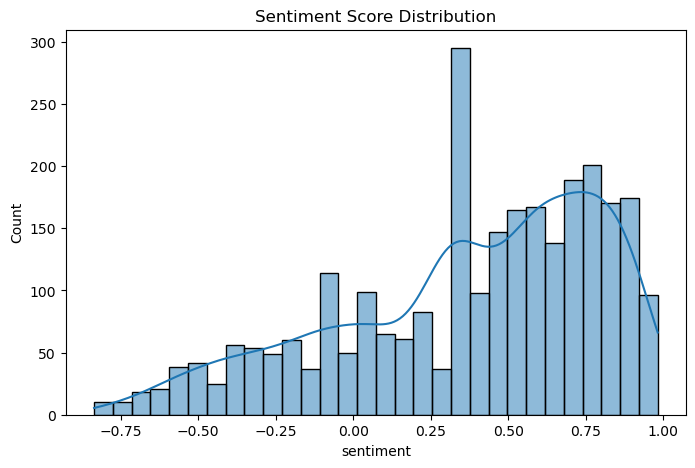

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df_model["sentiment"], bins=30, kde=True)
plt.title("Sentiment Score Distribution")
plt.show()

In [14]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


## TF-IDF Feature Extraction

To convert the cleaned ticket descriptions into numerical features, I used TF-IDF. 
This method highlights the words and short phrases that are most informative for distinguishing between different types of ticket. 

TF-IDF allows the model to learn which terms are associated with specific products, ticket types, or levels of customer satisfaction. It captures meanful variation in the language even though the dataset is relatively uniform in tone  and structure. 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=3000, #keep feature space manageable
    ngram_range=(1, 2), #unigrams + bigrams
    min_df=3 #ignore extremely rare words
)

X_tfidf = tfidf.fit_transform(df_model['clean_text'])
X_tfidf.shape

(2769, 2357)

In [12]:
feature_names = tfidf.get_feature_names_out()
feature_names[:20]

array(['able', 'able answer', 'able find', 'able make', 'able purchase',
       'accept', 'access', 'access account', 'access productpurchased',
       'accidentally', 'accidentally deleted', 'according', 'account',
       'account account', 'account click', 'account following',
       'account im', 'account ive', 'account keep', 'account locked'],
      dtype=object)

## Final Feature Matrix for Modeling

The final shape of the matrix is **(2779, 2360)**, meaning: 
- **2,769** closed tickets (one row per ticket)
- **2,360** total features, composed of:
    - TF-IDF text features
    - sentiment score
    - customer age
    - ticket description length

This combined feature set captures both the content and the tone of each ticket, along with the key structured metadata. 
It serves as the complete input for our predictive modeling work in Notebook 03.

In [13]:
from scipy.sparse import hstack

num_features = df_model[['sentiment', 'Customer Age', 'desc_word_count']].fillna(0)

X = hstack([X_tfidf, num_features.values])
y = df_model['Customer Satisfaction Rating'].values

X.shape, y.shape

((2769, 2360), (2769,))

In [15]:
# Save the enriched dataset with sentiment and clean_text for next notebooks
df_model[['clean_text', 'sentiment']].head()

# Merge back into full feature set
df_features = pd.read_csv('df_model_features.csv')
df_features['clean_text'] = df_model['clean_text']
df_features['sentiment'] = df_model['sentiment']

df_features.to_csv('df_model_features.csv', index=False)
print(f"Saved enriched features: {df_features.shape}")
df_features.head()

Saved enriched features: (2769, 20)


,Ticket ID,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,desc_word_count,desc_char_count,subject_word_count,clean_text,sentiment
0,3,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,NaN,NaN,3.0,42,275,2,im facing problem productpurchased productpurc...,0.1689
1,4,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,NaN,NaN,3.0,41,262,2,im issue productpurchased please assist proble...,0.8885
2,5,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,NaN,NaN,1.0,55,333,2,im issue productpurchased please assist note s...,0.4404
3,11,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,High,Phone,NaN,NaN,1.0,38,268,2,im issue productpurchased please assist produc...,0.8316
4,12,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,High,Chat,NaN,NaN,1.0,50,296,2,im issue productpurchased please assist possib...,0.8060
